In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c denoising-dirty-documents

 64% 14.0M/21.9M [00:00<00:00, 53.1MB/s]
100% 21.9M/21.9M [00:00<00:00, 73.0MB/s]
 63% 4.00M/6.30M [00:00<00:00, 38.6MB/s]
100% 6.30M/6.30M [00:00<00:00, 40.3MB/s]
 81% 15.0M/18.5M [00:00<00:00, 31.8MB/s]
100% 18.5M/18.5M [00:00<00:00, 41.7MB/s]
 75% 7.00M/9.39M [00:00<00:00, 39.9MB/s]
100% 9.39M/9.39M [00:00<00:00, 45.8MB/s]


In [ ]:
! unzip yolo-coco-data.zip -d yolo-coco

Archive:  yolo-coco-data.zip
  inflating: yolo-coco/coco.names    
  inflating: yolo-coco/yolov3.cfg    
  inflating: yolo-coco/yolov3.weights  


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [14]:
import os
for dirname, _, filenames in os.walk('/content/Denoising Dirty Documents/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/Denoising Dirty Documents/test.zip
/content/Denoising Dirty Documents/sampleSubmission.csv.zip
/content/Denoising Dirty Documents/train_cleaned.zip
/content/Denoising Dirty Documents/train.zip


In [15]:
# path to zipped & working directories
path_zip = '/content/Denoising Dirty Documents/'
path = '/content/working/'

In [16]:
# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [17]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [18]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [19]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

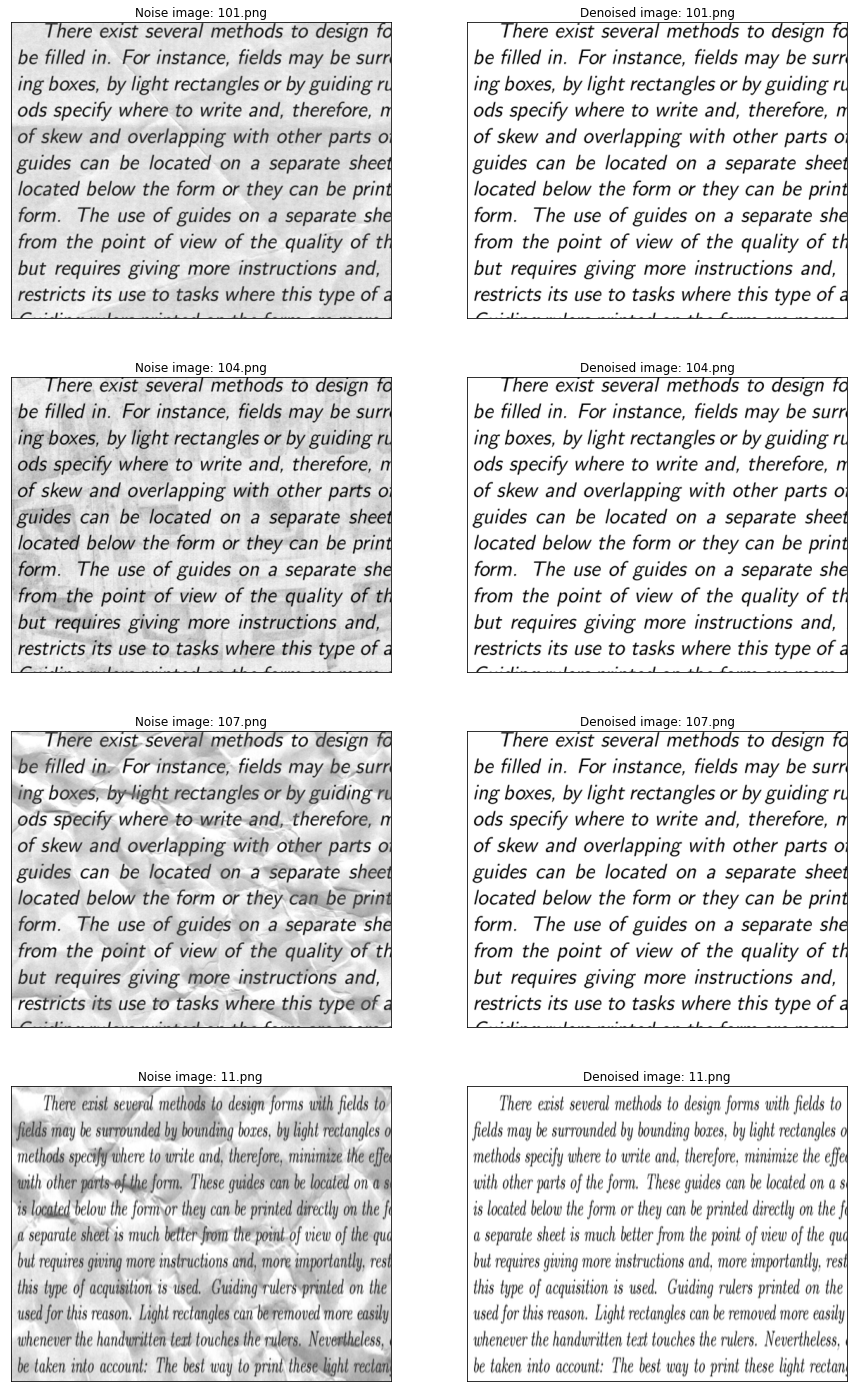

In [20]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [21]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [22]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 210, 270, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 270, 128)     147584

In [23]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=24, verbose=0, callbacks=[callback])

In [24]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

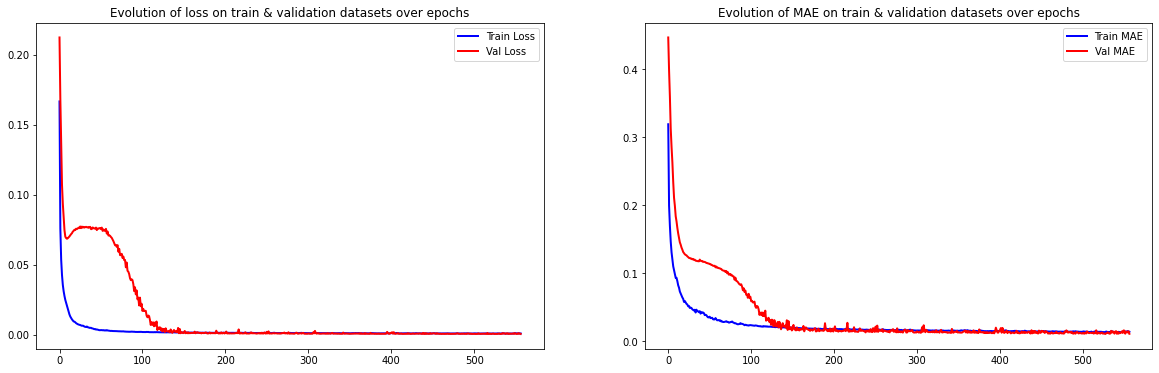

In [25]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [26]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

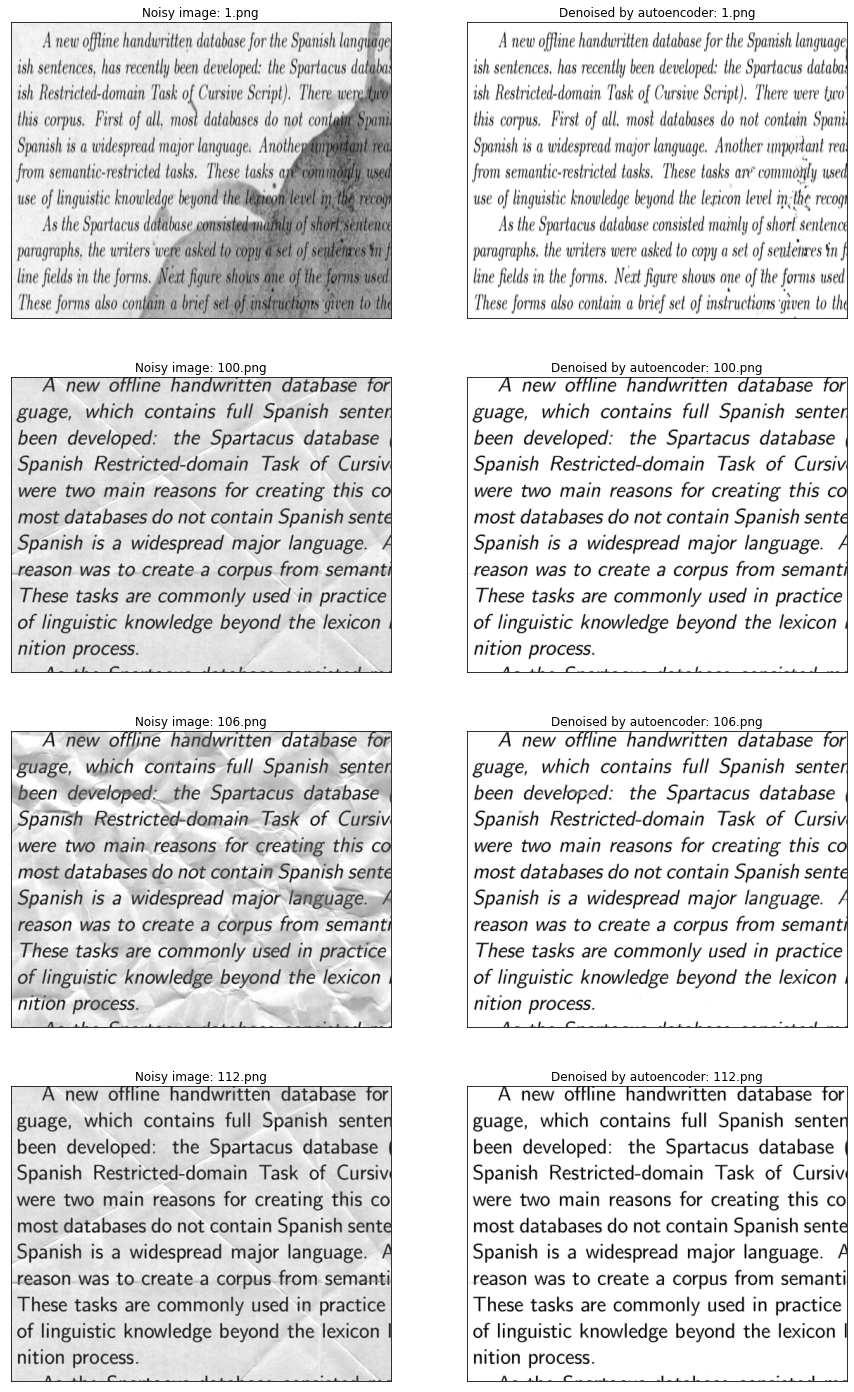

In [27]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [28]:
# it will take a while!
ids = []
vals = []
for i, f in enumerate(test_img):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    # print('Processing image: {} \tinto size: {}'.format(f, img_shape))    # uncomment to see progress
    preds_reshaped = cv2.resize(Y_test[i], (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

submission = pd.DataFrame({'id': ids, 'value': vals})
submission.to_csv('submission.csv',index = False)

print('Results saved to submission.csv!')

# quick check if length of IDs is OK
# we should get there number 14230080
print('Length of IDs: {}'.format(len(ids)))

Results saved to submission.csv!
Length of IDs: 14230080


In [29]:
# check first few rows of submission
my_submission = pd.read_csv('submission.csv')
my_submission.head(5)

,id,value
0,1_1_1,0.945958
1,1_1_2,0.987242
2,1_1_3,0.977226
3,1_1_4,0.993936
4,1_1_5,0.997716


In [30]:
# cleanup working directory
import shutil
shutil.rmtree(path + 'train/')
shutil.rmtree(path + 'test/')
shutil.rmtree(path + 'train_cleaned/')

In [31]:
model.save("image_denoising_autoencoders.h5")